#### importing the relevant packages and loading the data

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.preprocessing import StandardScaler

In [17]:
X = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")

#### Pre Processing

In [18]:
def extract_month(s):
    return int(s[5:7])

In [19]:
def pre_process(X, train = True):
    """
    Extracts the month out of date and converts it to a one hot
    Standardizes the numerical features
    Converts the city column to a boolean feature
    """
    # Converting the city column into a boolean, since we just have two cities
    is_sj = X.city == 'sj'

    #Extracting month from the date
    months = X.week_start_date.apply(extract_month)

    # Removing the dates info for now
    X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
    
    if train:
        # Dropping the rows with null values for now
        X.dropna(inplace=True)
    else:
        X.fillna(0,inplace=True)

    # Standardizing the data
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    # Adding the city boolean column
    X['is_sj'] = is_sj.loc[X.index]

    sliced_months = months.loc[X.index]
    # Month one hot features
    month_features = pd.get_dummies(sliced_months)
    X = X.join(month_features)

    # Alternatively use months as a discrete feature
    #X = X.join(sliced_months)
    
    return X

In [20]:
X = pre_process(X)

In [21]:
# Selecting y values corresponding to the filtered X values
y = y.total_cases.loc[X.index]

**splitting the data to train and test : **
Since this is timeseries data, we set the arguement shuffle to False

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, shuffle = False)

#### Random Model
Let us see the performance when we predict the number of cases for any given week to be equal to the mean number of cases in the past

In [23]:
y_p = np.full(len(Y_test), np.mean(Y_train))

In [24]:
mean_absolute_error(Y_test, y_p)

18.120148312940305

> The performance on this random model is the first benchmark that we shall improve upon

#### Baseline Model
A simple linear regression implementation from scikit learn

In [25]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

In [26]:
mean_absolute_error(Y_test, Y_pred)

12.63584611100273

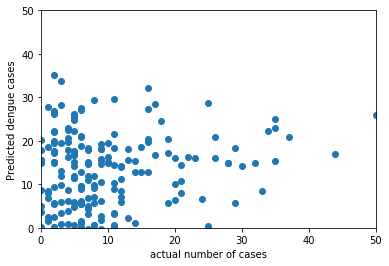

In [27]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

> From the graph we can see that this model isn't really good when there isn't even a slightly linear relationship between the actual and predicted values
 - let us try some feature selection to improve upon this

#### Recursive Feature Elimination

In [28]:
from sklearn.feature_selection import RFE

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select n attributes
rfe = RFE(model, 13)
rfe = rfe.fit(X, y)
X_Select = X.loc[:, rfe.support_]

# Split based on the newly selected features and train and test again
X_train, X_test, Y_train, Y_test = train_test_split(X_Select, y, shuffle = False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mean_absolute_error(Y_test, Y_pred)

9.697064561092054

> Eliminating some unnecessary features improves the accuracy, let us also try applying some regularization for further improvement!

#### L1
Linear Regression with L1 regularization

In [29]:
clf = linear_model.Lasso(alpha=0.5)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

8.198567106905848

#### L2
Linear Regression with L2 regularization

In [30]:
clf = linear_model.Ridge(alpha = 44)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

7.969390105082309

#### Conclusions : 
 - A simple linear model is only slightly better than a random model
 - Recursive feature elimination helps improve the accuracy
 - Regularization helps address the overfitting.
 
#### Next Steps :
 - Trying advanced ensemble models like the XGBoost
 - Improving the train - test distributions